In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [24]:
EXPERIMENT_NAME = 'P3856'
RUN_NAME = 'P3856_YHE211_1_Slot1-1_1_5104'
EXPERIMENT_DIR = '/data2/experiments/{}'.format(EXPERIMENT_NAME)

In [6]:
FEATURES_DIR = '{}/features-3did'.format(EXPERIMENT_DIR)
FEATURES_3DID_DEDUP_FILE = '{}/exp-{}-run-{}-features-3did-dedup.pkl'.format(FEATURES_DIR, EXPERIMENT_NAME, RUN_NAME)

features_3did_df = pd.read_pickle(FEATURES_3DID_DEDUP_FILE)

In [26]:
# load the PASEF de-duped features and constrain them to match the 3DID analysis parameters
FEATURES_DIR = '{}/recalibrated-features'.format(EXPERIMENT_DIR)
FEATURES_PASEF_DEDUP_FILE = '{}/exp-{}-run-{}-features-pasef-dedup.pkl'.format(FEATURES_DIR, EXPERIMENT_NAME, RUN_NAME)

features_pasef_df = pd.read_pickle(FEATURES_PASEF_DEDUP_FILE)

In [27]:
print('there are {} 3DID features before the de-dup step, {} from PASEF'.format(len(features_3did_df), len(features_pasef_df)))

there are 154131 3DID features before the de-dup step, 153390 from PASEF


In [28]:
features_pasef_df['intensity_log'] = np.log10(features_pasef_df.intensity)
features_pasef_df['method'] = 'pasef'
features_3did_df['intensity_log'] = np.log10(features_3did_df.intensity)
features_3did_df['method'] = '3did'

In [29]:
intensities_l = [features_pasef_df,features_3did_df]
intensities_df = pd.concat(intensities_l, sort=False)

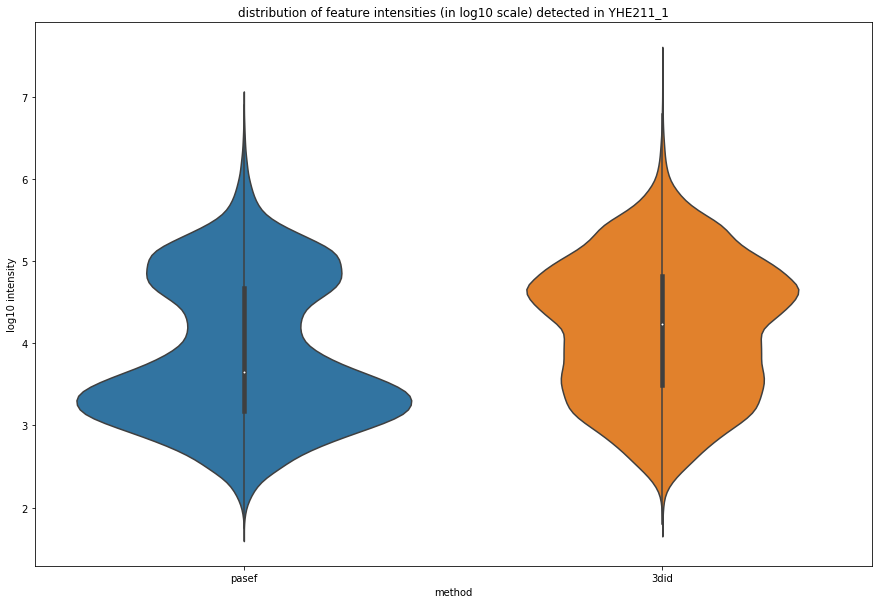

In [57]:
plt.figure(figsize=(15,10))
ax = sns.violinplot(x=intensities_df.method, y=intensities_df.intensity_log)
_ = plt.ylabel("log10 intensity")
_ = plt.title('distribution of feature intensities (in log10 scale) detected in YHE211_1')

#### show features found in common

In [31]:
MZ_TOLERANCE_PPM = 5
MZ_TOLERANCE_PERCENT = MZ_TOLERANCE_PPM * 10**-4
SCAN_TOLERANCE = 2
RT_TOLERANCE = 1

In [32]:
# set up the tolerances in each dimension
features_3did_df['mz'] = features_3did_df.monoisotopic_mz  # shorthand to reduce verbosity
features_3did_df['mz_ppm_tolerance'] = features_3did_df.mz * MZ_TOLERANCE_PERCENT / 100
features_3did_df['mz_lower'] = features_3did_df.mz - features_3did_df.mz_ppm_tolerance
features_3did_df['mz_upper'] = features_3did_df.mz + features_3did_df.mz_ppm_tolerance
features_3did_df['scan_lower'] = features_3did_df.scan_apex - SCAN_TOLERANCE
features_3did_df['scan_upper'] = features_3did_df.scan_apex + SCAN_TOLERANCE
features_3did_df['rt_lower'] = features_3did_df.rt_apex - RT_TOLERANCE
features_3did_df['rt_upper'] = features_3did_df.rt_apex + RT_TOLERANCE

In [33]:
features_pasef_df['mz'] = features_pasef_df.recalibrated_monoisotopic_mz  # shorthand to reduce verbosity

In [34]:
# find feature pairs in 3DID and PASEF
feature_pairs_l = []  # (feature_3did_id, intensity, feature_pasef_id, intensity)
for row in features_3did_df.itertuples():
    pair_df = features_pasef_df[(features_pasef_df.mz > row.mz_lower) & (features_pasef_df.mz < row.mz_upper) & (features_pasef_df.scan_apex > row.scan_lower) & (features_pasef_df.scan_apex < row.scan_upper) & (features_pasef_df.rt_apex > row.rt_lower) & (features_pasef_df.rt_apex < row.rt_upper)].copy()
    # group the dups by charge - take the most intense for each charge
    for group_name,group_df in pair_df.groupby(['charge'], as_index=False):
        pasef_feature = group_df.iloc[0]
        feature_pairs_l.append((row.feature_id, row.intensity, pasef_feature.feature_id, pasef_feature.intensity))
        

In [39]:
feature_pairs_df = pd.DataFrame(feature_pairs_l, columns=['3did_feature_id','3did_intensity','pasef_feature_id','pasef_intensity'])

In [52]:
pasef_only_df = features_pasef_df[(~features_pasef_df.feature_id.isin(feature_pairs_df.pasef_feature_id.tolist()))]
threedid_only_df = features_3did_df[(~features_3did_df.feature_id.isin(feature_pairs_df['3did_feature_id'].tolist()))]


In [54]:
len(pasef_only_df), len(threedid_only_df), len(feature_pairs_df)

(144279, 145017, 9203)

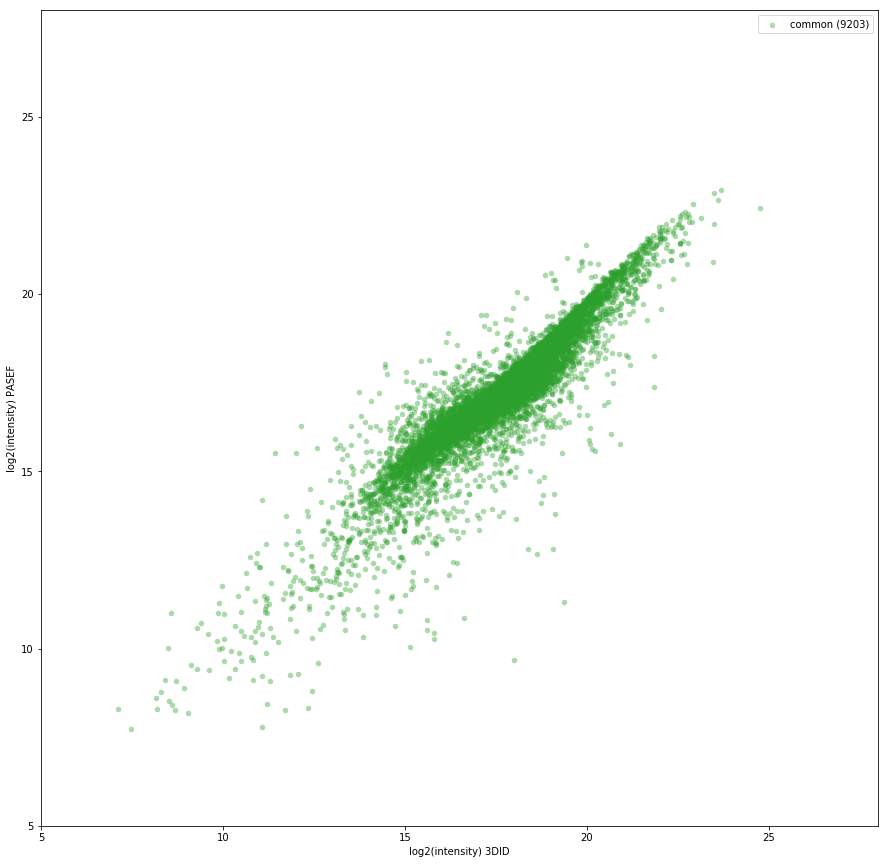

In [55]:
f, ax = plt.subplots()
f.set_figheight(15)
f.set_figwidth(15)
plt.margins(0.06)

title = ''
plt.title(title)

ax.scatter(np.log2(feature_pairs_df['3did_intensity']), np.log2(feature_pairs_df.pasef_intensity), marker='o', color='tab:green', lw=0, s=30, alpha=0.4, label="common ({})".format(len(feature_pairs_df)))

plt.legend(loc='best')
plt.xlabel('log2(intensity) 3DID')
plt.ylabel('log2(intensity) PASEF')

plt.xlim((5,28))
plt.ylim((5,28))

plt.show()